# **Notebook resources**

In [39]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install geopandas
!pip install category_encoders
!pip install catboost
!pip install xgboost
!pip install shap

In [41]:
import pandas as pd
import numpy as np
import os

In [42]:
# SET CUSTOM MODULES FOLDER
import sys
sys.path.append('/content/drive/MyDrive/Kschool_TFM/src/modules/')

# CUSTOM MODULES
import model_funcs as mf
import viz_funcs as vf
import other_funcs as of

In [43]:
datasets_folder = '/content/drive/MyDrive/Kschool_TFM/datasets'

In [44]:
df = pd.read_csv(f'{datasets_folder}{os.sep}dataset-03-AV.csv')

In [45]:
df.dtypes

id                       int64
propertyType            object
title                   object
price                  float64
size                   float64
hasParking             float64
roomNumber             float64
bathNumber             float64
hasSwimmingPool        float64
hasTerrace             float64
hasGarden              float64
hasLift                float64
hasAirco               float64
isGoodCondition        float64
isNeedsRenovating      float64
isNewDevelopment       float64
energyCertification     object
heatingType             object
floor                    int64
district                object
dataset                 object
hasHeatingInfo         float64
price_m2               float64
room_bath_rate         float64
size_time_baths        float64
floor_height            object
propertyCondition        int64
dtype: object

# **Feature engineering**

## **Price m2 from Fotocasa - Scraping (test)**

With this fragment we intend to add a new feature to the dataset extracted externally, so that it can be added without relying on the price. The objective is to add the average price and the price per square metre of each district and for this purpose we developed a small scraping code on Fotocasa. Subsequently we saw that in some encodings it provided collinearity with the district feature itself.

In [46]:
df = of.fotocasa_m2_scraping(df)

,district,price_m2_ft,mean_price
0,Barajas,3283.0,369067.0
1,Vicálvaro,2771.0,245867.0
2,Villa de Vallecas,2559.0,201506.0
3,Usera,2356.0,199243.0
4,Fuencarral,3971.0,446856.0
5,San Blas,2917.0,249270.0
6,Villaverde,1986.0,156871.0
7,Retiro,5413.0,662680.0
8,Puente de Vallecas,2272.0,158960.0
9,Moncloa,4626.0,596194.0


In [ ]:
df.columns

Index(['id', 'propertyType', 'title', 'price', 'size', 'hasParking',
       'roomNumber', 'bathNumber', 'hasSwimmingPool', 'hasTerrace',
       'hasGarden', 'hasLift', 'hasAirco', 'isGoodCondition',
       'isNeedsRenovating', 'isNewDevelopment', 'energyCertification',
       'heatingType', 'floor', 'district', 'dataset', 'hasHeatingInfo',
       'price_m2', 'room_bath_rate', 'size_time_baths', 'floor_height',
       'propertyCondition', 'price_m2_ft', 'mean_price'],
      dtype='object')

## **Dataset features preparation**

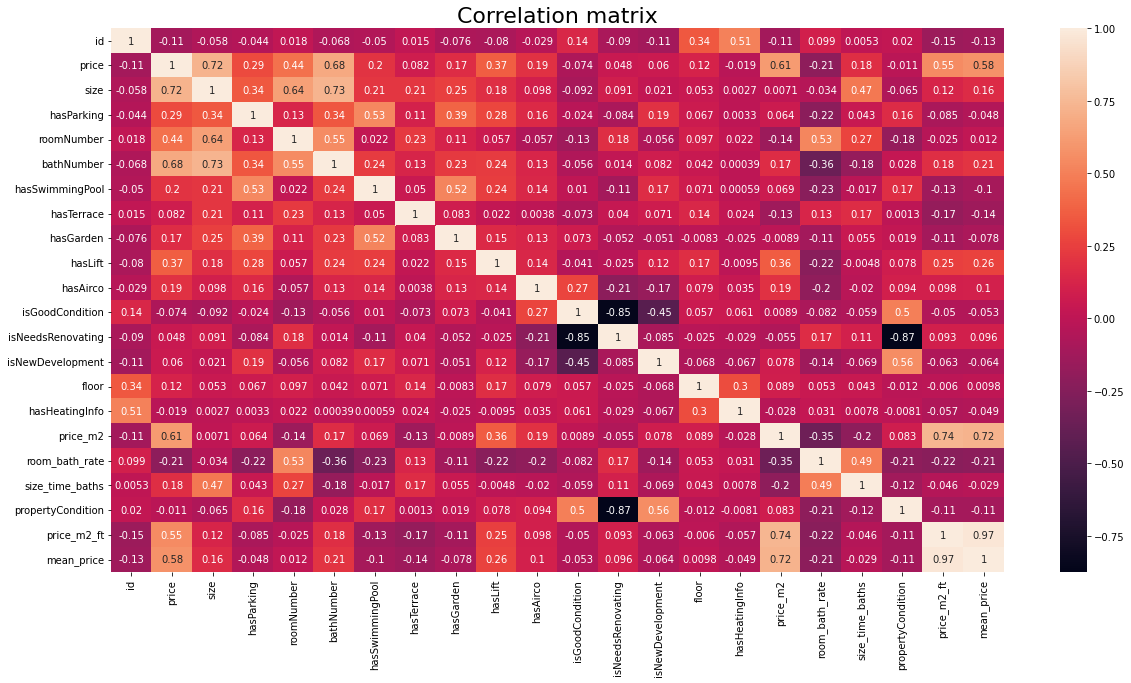

In [47]:
vf.plot_correlation_matrix(df)

At this point we remove all features that we are not going to use in the model, either because of colinearity or because they were only for analytical purposes.

We will also remove energyCertification, heatingType and hasHeatingInfo because they were not representative of the dataset since too few records have data about these features.

We will then remove floor and floor_height as they do not show a direct correlation with the price as the advantage or disadvantage of a specific floor might depend on other factors, such as if the property is bright or not, and those cannot simply be inferred by the floor number. 

Finally we will remove the propertyCondition, isGoodCondition and isNeedsRenovating as their correlation with the price is not accorded to what they represent.

In [48]:
features_to_drop =['id','title','isGoodCondition', 'isNeedsRenovating', 'energyCertification',
                   'heatingType', 'floor', 'dataset', 'hasHeatingInfo', 'price_m2',
                   'room_bath_rate', 'size_time_baths', 'floor_height', 'propertyCondition','mean_price']
df_clean = df.drop(features_to_drop, axis=1)
del features_to_drop

In [49]:
df_clean.columns

Index(['propertyType', 'price', 'size', 'hasParking', 'roomNumber',
       'bathNumber', 'hasSwimmingPool', 'hasTerrace', 'hasGarden', 'hasLift',
       'hasAirco', 'isNewDevelopment', 'district', 'price_m2_ft'],
      dtype='object')

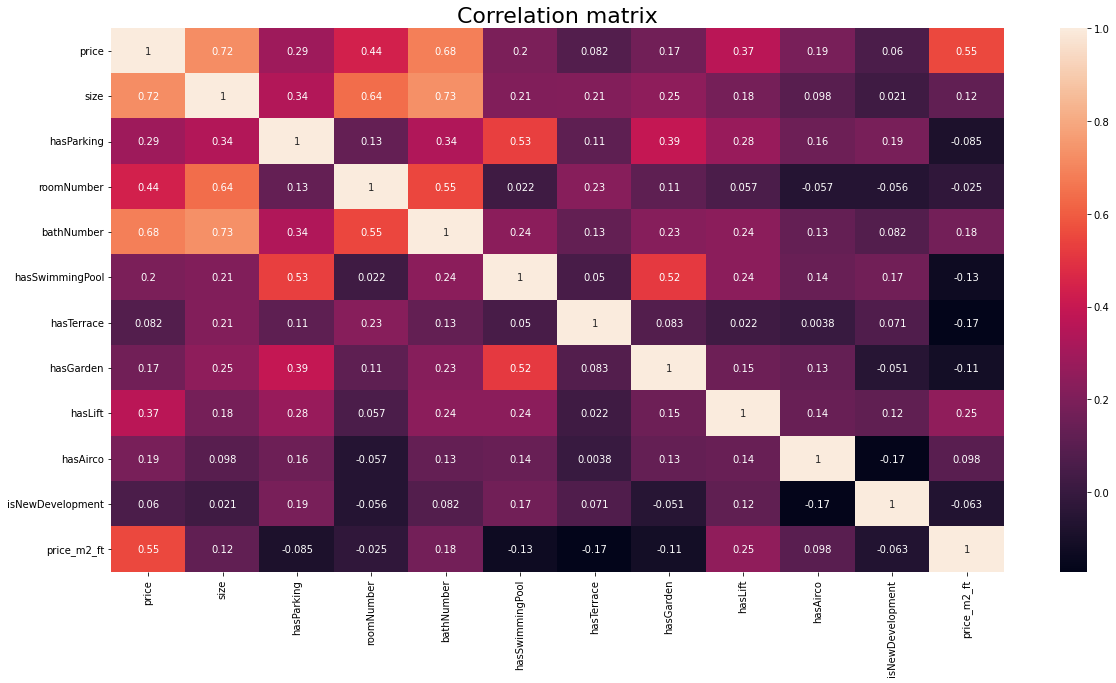

In [50]:
vf.plot_correlation_matrix(df_clean)

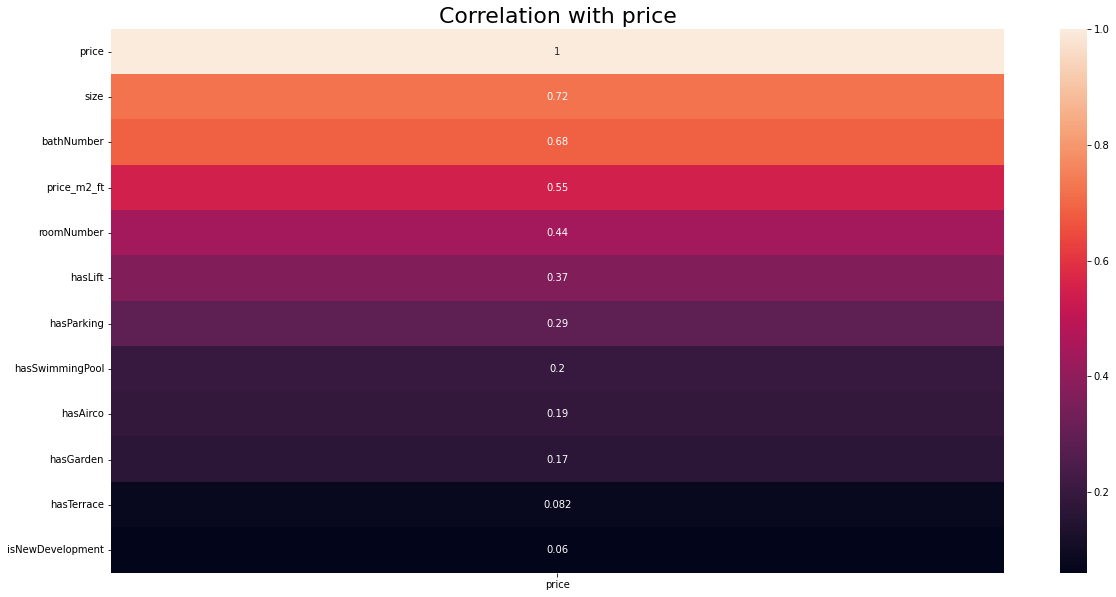

In [51]:
vf.plot_feature_correlation_matrix(df_clean,'price')

## **Target Encoding approach**

To train the model it is necessary to convert the categorical features into numerical ones, although we also saw that some boosting models can do the conversion directly. Still, we wanted to test three types of encoding and then confront them in different models.

First, we tested target encoding, since it does not increase the number of features and encodes categorical variables according to price.

In [ ]:
df_target_encoding = mf.target_encode(df_clean)
df_target_encoding.head()

,price,size,hasParking,roomNumber,bathNumber,hasSwimmingPool,hasTerrace,hasGarden,hasLift,hasAirco,isNewDevelopment,price_m2_ft,propertyType,district
0,995000.0,179.0,0.0,4.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,4383.0,361829.556247,394642.177143
1,315000.0,96.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,3283.0,361829.556247,412292.064439
2,265000.0,64.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2498.0,361829.556247,199801.085297
3,136000.0,55.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2272.0,361829.556247,170324.599624
4,194400.0,197.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1986.0,625395.597378,158388.091319


Brief analysis of the dataset with target-encoding

In [ ]:
df_target_encoding.describe().T

,count,mean,std,min,25%,50%,75%,max
price,22078.0,371466.182218,255764.918586,11900.000000,175000.000000,285000.000000,487000.000000,1.224000e+06
size,22078.0,94.972371,51.092196,21.000000,62.000000,84.000000,115.000000,9.760000e+02
hasParking,22078.0,0.275840,0.446947,0.000000,0.000000,0.000000,1.000000,1.000000e+00
roomNumber,22078.0,2.496739,1.115418,0.000000,2.000000,3.000000,3.000000,6.000000e+00
bathNumber,22078.0,1.567126,0.727800,1.000000,1.000000,1.000000,2.000000,5.000000e+00
hasSwimmingPool,22078.0,0.158755,0.365456,0.000000,0.000000,0.000000,0.000000,1.000000e+00
hasTerrace,22078.0,0.385814,0.486798,0.000000,0.000000,0.000000,1.000000,1.000000e+00
hasGarden,22078.0,0.176012,0.380839,0.000000,0.000000,0.000000,0.000000,1.000000e+00
hasLift,22078.0,0.680678,0.466225,0.000000,0.000000,1.000000,1.000000,1.000000e+00
hasAirco,22078.0,0.529305,0.499152,0.000000,0.000000,1.000000,1.000000,1.000000e+00


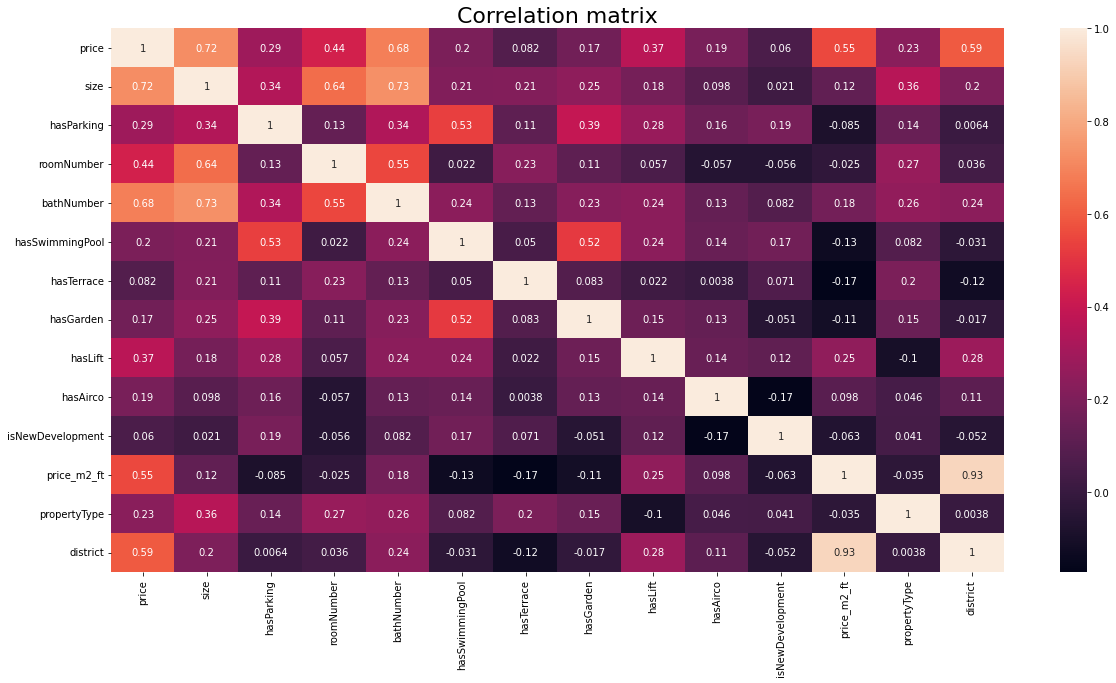

In [ ]:
vf.plot_correlation_matrix(df_target_encoding)


We will remove "price_m2_ft" because of its high correlation with district (0.93), since they are all providing similar information.

In [ ]:
df_target_encoding = df_target_encoding.drop(['price_m2_ft'],axis=1)

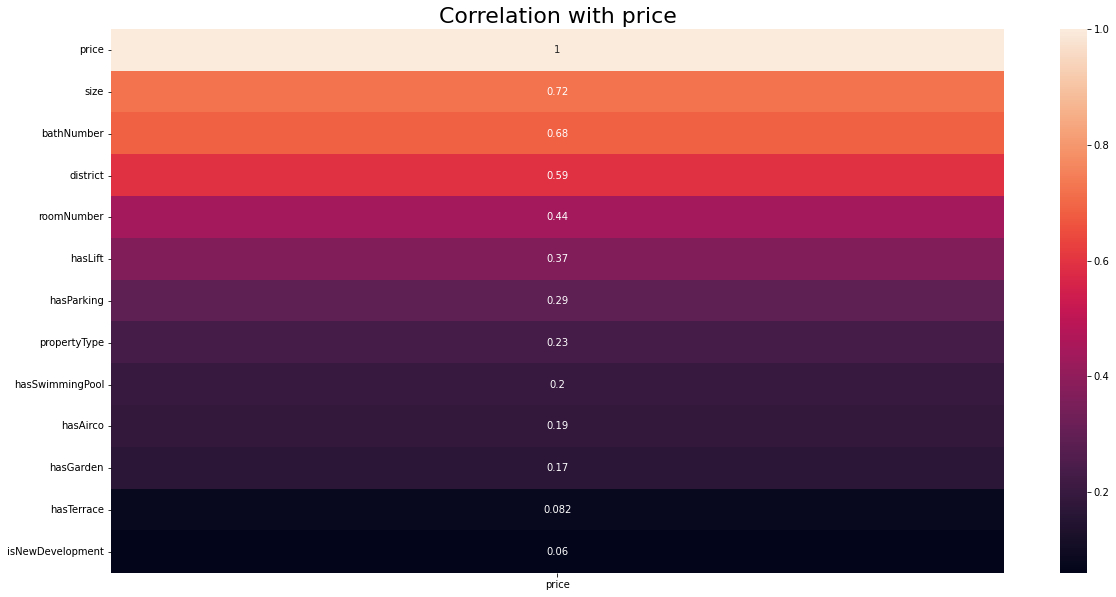

In [ ]:
vf.plot_feature_correlation_matrix(df_target_encoding,'price')

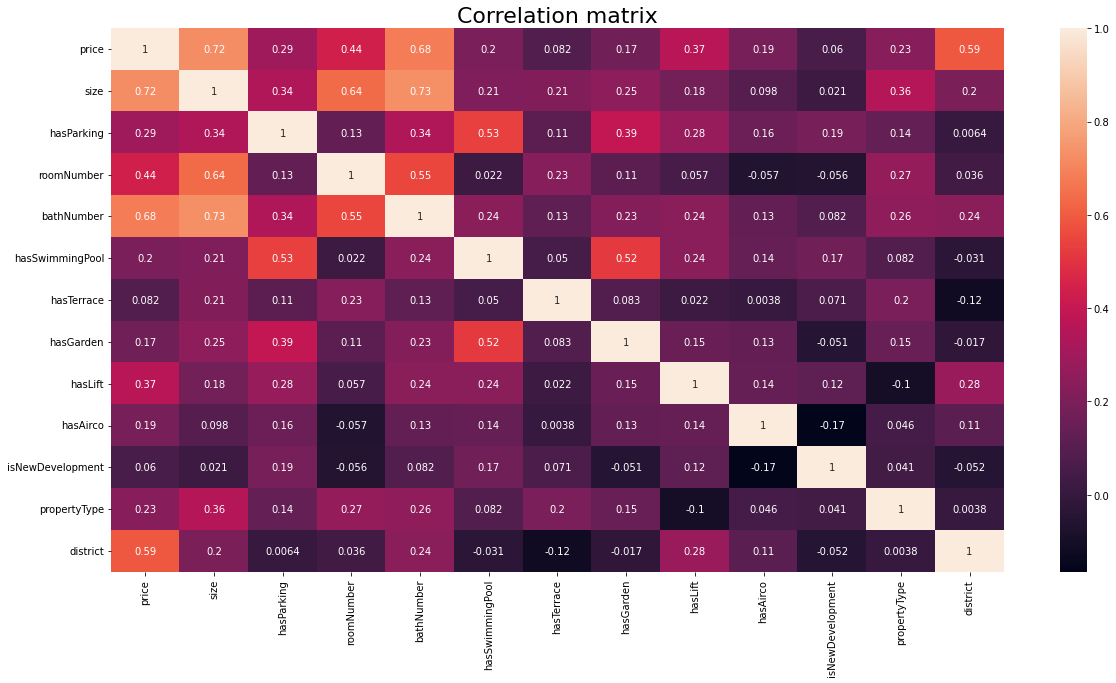

In [ ]:
vf.plot_correlation_matrix(df_target_encoding)

## **One Hot Encoding approach**

Secondly, we create another dataframe with One Hot Encoding, which in this case increases the number of features considerably.

In [52]:
df_one_hot_encoding = mf.one_hot_encode(df_clean,download=True)

oneHotEncoder saved as pickle file.


In [53]:
df_one_hot_encoding.columns

Index(['price', 'size', 'hasParking', 'roomNumber', 'bathNumber',
       'hasSwimmingPool', 'hasTerrace', 'hasGarden', 'hasLift', 'hasAirco',
       'isNewDevelopment', 'price_m2_ft', 'atico', 'chalet', 'duplex',
       'estudio', 'loft', 'piso', 'Arganzuela', 'Barajas',
       'Barrio de Salamanca', 'Carabanchel', 'Centro', 'Chamartin', 'Chamberí',
       'Ciudad Lineal', 'Fuencarral', 'Hortaleza', 'Latina', 'Moncloa',
       'Moratalaz', 'Puente de Vallecas', 'Retiro', 'San Blas', 'Tetuán',
       'Usera', 'Vicálvaro', 'Villa de Vallecas', 'Villaverde'],
      dtype='object')

In [ ]:
df_one_hot_encoding.describe().T

,count,mean,std,min,25%,50%,75%,max
price,22078.0,371466.182218,255764.918586,11900.0,175000.0,285000.0,487000.0,1224000.0
size,22078.0,94.972371,51.092196,21.0,62.0,84.0,115.0,976.0
hasParking,22078.0,0.275840,0.446947,0.0,0.0,0.0,1.0,1.0
roomNumber,22078.0,2.496739,1.115418,0.0,2.0,3.0,3.0,6.0
bathNumber,22078.0,1.567126,0.727800,1.0,1.0,1.0,2.0,5.0
hasSwimmingPool,22078.0,0.158755,0.365456,0.0,0.0,0.0,0.0,1.0
hasTerrace,22078.0,0.385814,0.486798,0.0,0.0,0.0,1.0,1.0
hasGarden,22078.0,0.176012,0.380839,0.0,0.0,0.0,0.0,1.0
hasLift,22078.0,0.680678,0.466225,0.0,0.0,1.0,1.0,1.0
hasAirco,22078.0,0.529305,0.499152,0.0,0.0,1.0,1.0,1.0


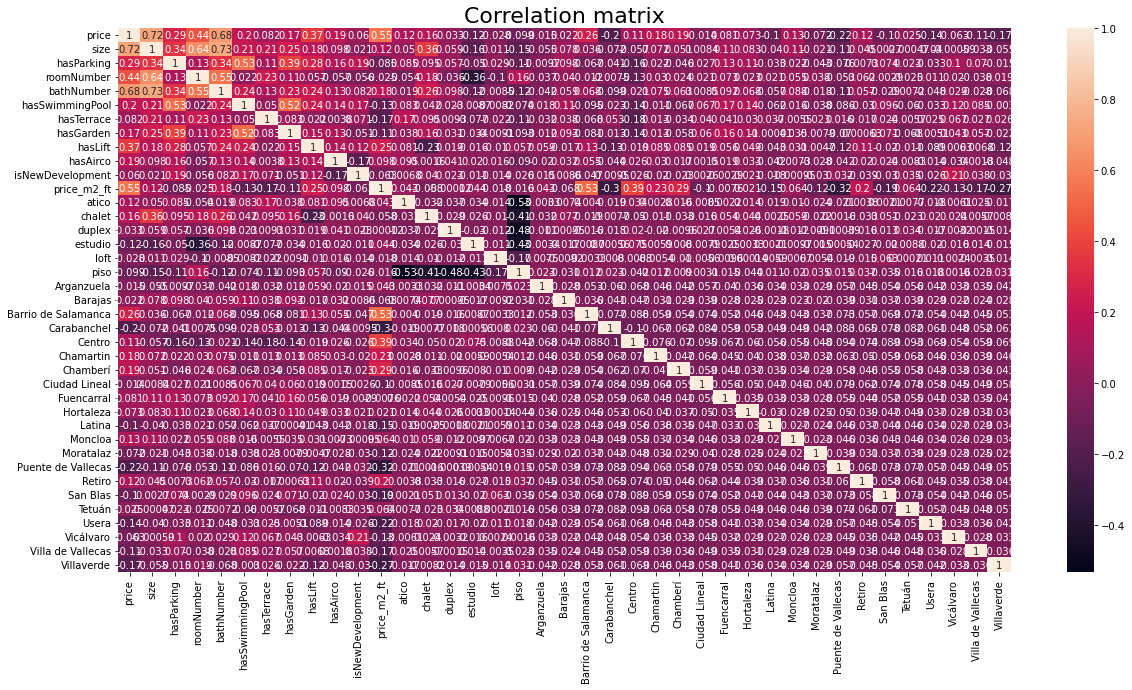

In [ ]:
vf.plot_correlation_matrix(df_one_hot_encoding)

It was difficult to see the correlations with the plot_correlation_matrix function, so we see it directly with Pandas.

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df_one_hot_encoding.corr()

,price,size,hasParking,roomNumber,bathNumber,hasSwimmingPool,hasTerrace,hasGarden,hasLift,hasAirco,isNewDevelopment,price_m2_ft,atico,chalet,duplex,estudio,loft,piso,Arganzuela,Barajas,Barrio de Salamanca,Carabanchel,Centro,Chamartin,Chamberí,Ciudad Lineal,Fuencarral,Hortaleza,Latina,Moncloa,Moratalaz,Puente de Vallecas,Retiro,San Blas,Tetuán,Usera,Vicálvaro,Villa de Vallecas,Villaverde
price,1.000000,0.722702,0.290111,0.439721,0.684986,0.198065,0.081959,0.170167,0.366474,0.187746,0.060164,0.551847,0.120799,0.156311,0.032563,-0.115615,-0.027791,-0.098745,-0.015143,0.022202,0.260231,-0.198884,0.109262,0.181275,0.189892,-0.014085,0.081169,0.072976,-0.103186,0.134967,-0.072340,-0.219534,0.118995,-0.100196,0.025115,-0.138609,-0.062718,-0.105464,-0.170449
size,0.722702,1.000000,0.342489,0.639902,0.731193,0.211209,0.212826,0.248918,0.178137,0.097775,0.020991,0.123605,0.049678,0.362000,0.058576,-0.164644,0.010585,-0.149644,-0.055366,0.078042,0.036173,-0.071734,-0.057153,0.071579,0.051281,0.008440,0.108187,0.082529,-0.040411,0.110398,-0.021322,-0.109924,0.044932,0.002731,-0.000467,-0.039743,-0.000591,-0.032744,-0.054832
hasParking,0.290111,0.342489,1.000000,0.130460,0.337568,0.531380,0.113336,0.391738,0.275343,0.155633,0.189023,-0.084636,0.084814,0.095454,0.056760,-0.050476,0.029487,-0.105272,-0.009675,0.098354,-0.067256,-0.041128,-0.158813,0.021638,-0.046354,0.026730,0.134848,0.111732,-0.033101,0.021799,-0.042710,-0.076405,0.007279,0.073794,0.023448,-0.032824,0.102983,0.070348,-0.015312
roomNumber,0.439721,0.639902,0.130460,1.000000,0.550176,0.021994,0.230473,0.114486,0.057314,-0.056940,-0.055816,-0.025485,-0.054118,0.182845,-0.035925,-0.364215,-0.102649,0.162863,-0.037268,0.039840,-0.011789,-0.007482,-0.132853,0.029592,0.023642,0.021335,0.072555,0.023045,0.021066,0.055485,0.038338,-0.053440,0.062490,-0.002941,-0.024827,0.011205,0.020280,-0.038498,0.019313
bathNumber,0.684986,0.731193,0.337568,0.550176,1.000000,0.236754,0.125577,0.225545,0.237913,0.131115,0.081905,0.175725,0.019193,0.255277,0.098275,-0.117689,-0.008480,-0.122507,-0.042341,0.058553,0.068041,-0.098842,-0.021475,0.075402,0.062684,0.008506,0.091999,0.068392,-0.057261,0.088157,-0.018207,-0.112984,0.057284,-0.028958,0.007200,-0.047517,0.029412,-0.028401,-0.068469
hasSwimmingPool,0.198065,0.211209,0.531380,0.021994,0.236754,1.000000,0.050342,0.518791,0.238523,0.142476,0.170639,-0.129287,0.083133,0.042132,0.022553,-0.008736,-0.008244,-0.074247,0.018369,0.114888,-0.094563,-0.022706,-0.137210,-0.011467,-0.067257,0.066653,0.167513,0.143869,-0.062276,0.015940,-0.038203,-0.086327,-0.029640,0.095559,-0.060211,-0.032733,0.122956,0.084733,-0.003040
hasTerrace,0.081959,0.212826,0.113336,0.230473,0.125577,0.050342,1.000000,0.083493,0.022351,0.003799,0.071060,-0.172185,0.173999,0.095073,0.009322,-0.077357,-0.021699,-0.109061,-0.031924,0.038422,-0.068124,0.053451,-0.180006,0.012643,-0.034393,0.040194,0.040961,0.030037,0.037279,-0.005543,0.023447,0.015537,-0.017404,0.023772,-0.005660,0.024862,0.066514,0.026861,0.025958
hasGarden,0.170167,0.248918,0.391738,0.114486,0.225545,0.518791,0.083493,1.000000,0.153036,0.131082,-0.050615,-0.110951,0.037662,0.156389,0.030892,-0.033607,-0.009123,-0.092522,-0.011690,0.093485,-0.080655,-0.012948,-0.140234,0.013108,-0.057837,0.060277,0.162339,0.113431,-0.000405,0.034566,-0.007902,-0.069770,0.000631,0.071074,-0.067565,-0.005145,0.043200,0.057241,-0.022484
hasLift,0.366474,0.178137,0.275343,0.057314,0.237913,0.238523,0.022351,0.153036,1.000000,0.140453,0.120006,0.252531,0.081488,-0.228595,0.019282,-0.015832,-0.010320,0.057164,0.058593,-0.016522,0.126194,-0.127316,-0.019434,0.084906,0.084790,0.018534,0.055587,0.049402,-0.043425,0.031440,-0.004718,-0.117559,0.112057,-0.020145,-0.011349,-0.089265,-0.006280,0.006822,-0.120598
hasAirco,0.187746,0.097775,0.155633,-0.056940,0.131115,0.142476,0.003799,0.131082,0.140453,1.000000,-0.165478,0.098127,0.094987,-0.001565,0.041462,0.019596,0.015994,-0.089570,-0.020302,0.032069,0.055080,-0.044381,0.026306,0.030274,0.0174

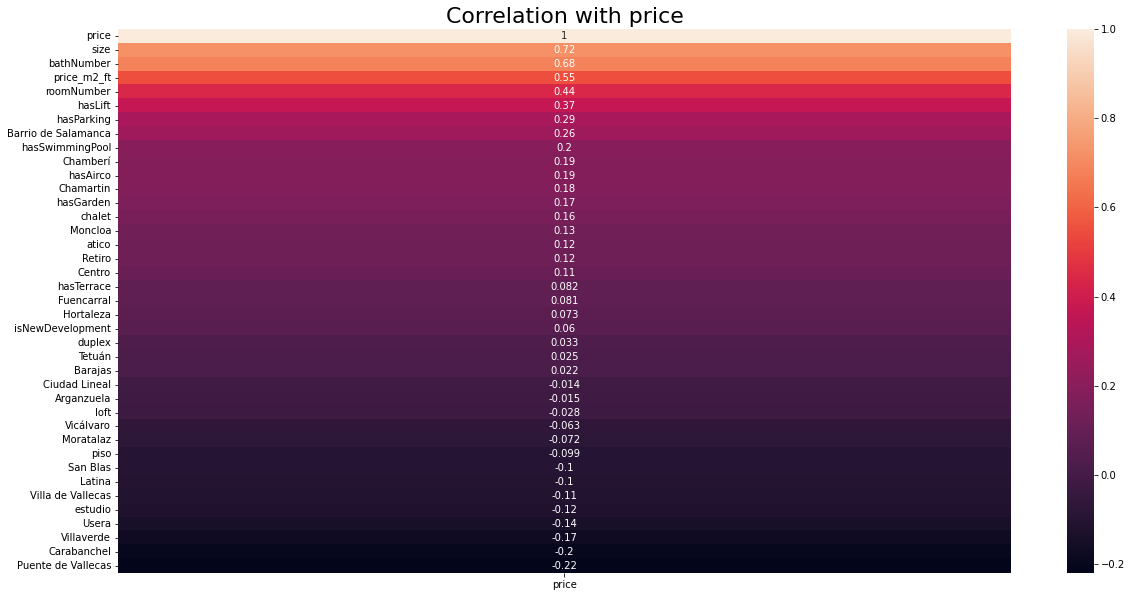

In [ ]:
vf.plot_feature_correlation_matrix(df_one_hot_encoding,'price')

## One Hot encoding approach (joining propertyType and hasLift)

As we saw, the only two categorical features worth using are propertyType and district and should be encoded with OneHot encoding since the correlation with the price is not linear

In [ ]:
df_one_hot_encoding_less = df_clean.copy()

In [ ]:
district_one_hot = pd.get_dummies(df_one_hot_encoding_less['district'])

In [ ]:
df_one_hot_encoding_less = df_one_hot_encoding_less.merge(district_one_hot, left_index=True, right_index=True)

Let's make hasLift only available for properties that are not chalets

In [ ]:
df_one_hot_encoding_less['propertyType'] = df_one_hot_encoding_less['propertyType']+"_"+df_one_hot_encoding_less['hasLift'].apply(lambda x: 'con_ascensor' if x == 1 else 'sin_ascensor')
df_one_hot_encoding_less['propertyType'] = df_one_hot_encoding_less['propertyType'].apply(lambda x: 'chalet' if 'chalet' in x else x)
df_one_hot_encoding_less['propertyType']

0        piso_con_ascensor
1        piso_con_ascensor
2        piso_con_ascensor
3        piso_sin_ascensor
4                   chalet
               ...        
22073    piso_con_ascensor
22074    piso_con_ascensor
22075               chalet
22076    piso_sin_ascensor
22077    piso_sin_ascensor
Name: propertyType, Length: 22078, dtype: object

In [ ]:
propertyType_one_hot = pd.get_dummies(df_one_hot_encoding_less['propertyType'])

In [ ]:
df_one_hot_encoding_less = df_one_hot_encoding_less.merge(propertyType_one_hot, left_index=True, right_index=True)

In [ ]:
df_one_hot_encoding_less = df_one_hot_encoding_less.drop(['district','propertyType','hasLift'], axis=1)

In [ ]:
df_one_hot_encoding_less.dtypes

price                   float64
size                    float64
hasParking              float64
roomNumber              float64
bathNumber              float64
hasSwimmingPool         float64
hasTerrace              float64
hasGarden               float64
hasAirco                float64
isNewDevelopment        float64
price_m2_ft             float64
Arganzuela                uint8
Barajas                   uint8
Barrio de Salamanca       uint8
Carabanchel               uint8
Centro                    uint8
Chamartin                 uint8
Chamberí                  uint8
Ciudad Lineal             uint8
Fuencarral                uint8
Hortaleza                 uint8
Latina                    uint8
Moncloa                   uint8
Moratalaz                 uint8
Puente de Vallecas        uint8
Retiro                    uint8
San Blas                  uint8
Tetuán                    uint8
Usera                     uint8
Vicálvaro                 uint8
Villa de Vallecas         uint8
Villaver

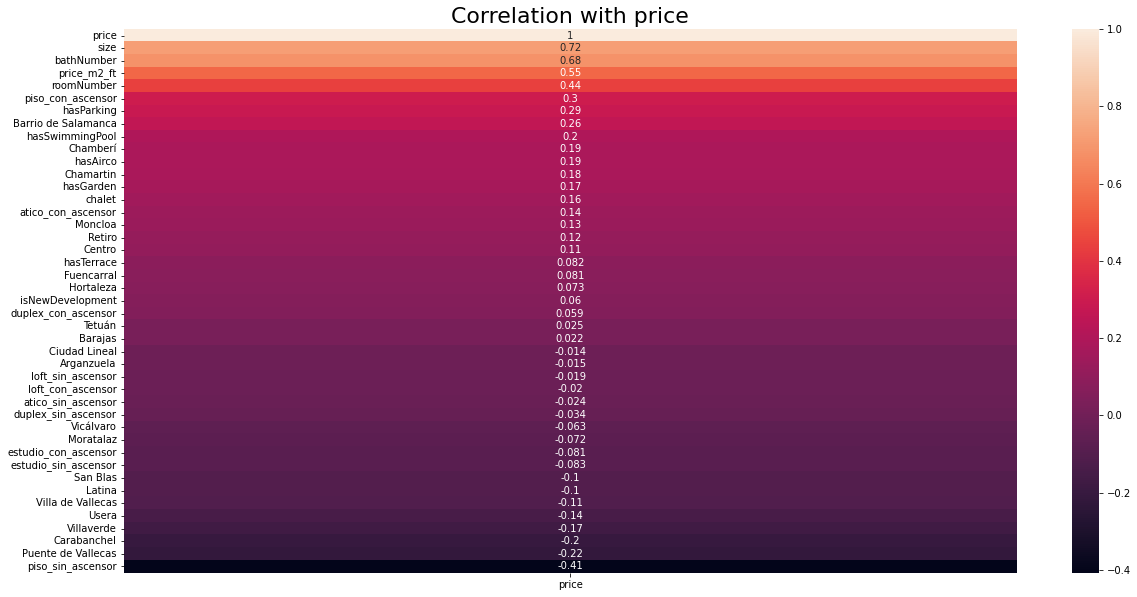

In [ ]:
vf.plot_feature_correlation_matrix(df_one_hot_encoding_less,'price')

# **Saving datasets**

In [ ]:
datasets_folder = '/content/drive/MyDrive/Kschool_TFM/datasets'
df_clean.to_csv(f'{datasets_folder}{os.sep}dataset-04-fe_clean.csv',index=False)
df_one_hot_encoding.to_csv(f'{datasets_folder}{os.sep}dataset-04-fe_one_hot_encoding.csv',index=False)
df_target_encoding.to_csv(f'{datasets_folder}{os.sep}dataset-04-fe_target_encoding.csv',index=False)
df_one_hot_encoding_less.to_csv(f'{datasets_folder}{os.sep}dataset-04-fe_one_hot_encoding_less.csv',index=False)